## 난임 환자 대상 임신 성공 여부 예측

### LGAimers 6th 온라인 해커톤

Import

In [195]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import os
from pprint import pprint

from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    f1_score,
    precision_score,
    recall_score,
    roc_auc_score,
    roc_curve
)
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from sklearn.preprocessing import OrdinalEncoder
from tqdm import tqdm

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

import optuna
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import OrdinalEncoder


In [196]:
import platform
from matplotlib import rc

# 운영 체제에 따라 폰트 설정
if platform.system() == 'Windows':  # Windows 환경
    rc('font', family='Malgun Gothic')  # 맑은 고딕

# 음수 표시 가능하도록 설정
plt.rcParams['axes.unicode_minus'] = False

반복적으로 쓰는 함수툴

In [197]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

def plot_box(df, col_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    """
    plt.figure(figsize=(7, 4))
    plt.boxplot(df[col_name], vert=False)
    plt.xlabel(col_name)
    plt.title(f'Box Plot of {col_name}')
    plt.show()

def value_counts_ratio(df, col_name, target_name='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

def summarize_group(df, group_by_columns):
    """
    주어진 데이터프레임을 특정 열들로 그룹화하여 각 그룹의 '임신_성공_여부' 비율과 갯수를 요약하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_columns (list): 그룹화할 열 이름들의 리스트
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '임신 성공' 비율과 갯수 계산
        success_count = group['임신_성공_여부'].value_counts().get(1, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'임신_성공_여부' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)

def plot_ratio(df, group_by_column, target_column='임신_성공_여부', success_value=1):
    """
    주어진 데이터프레임을 특정 열로 그룹화하여 각 그룹의 타겟 변수의 성공 비율을 시각화하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    group_by_column (str): 그룹화할 열 이름
    target_column (str): 타겟 변수 이름
    success_value (int): 타겟 변수의 성공을 나타내는 값
    """
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_column)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # '임신_성공_여부' 변수의 '성공' 비율과 갯수 계산
        success_count = group[target_column].value_counts().get(success_value, 0)
        success_ratio = success_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, success_count, success_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', f"'{success_value}' count", 'ratio', 'Total'])
    
    # 그래프 크기 설정
    plt.figure(figsize=(10, 5))
    
    # 막대 그래프 생성
    ax = results_df.plot(kind='bar', x='group', y='ratio', legend=False)
    
    # 각 막대 위에 임신 성공 여부 갯수와 총 갯수 표시
    for i, (success_count, total) in enumerate(zip(results_df[f"'{success_value}' count"], results_df['Total'])):
        ax.text(i, results_df['ratio'][i], f'{success_count} ({total})', ha='center', va='bottom', fontsize=8)
    
    # 그래프 제목 및 축 레이블 설정
    ax.set_title(f'{success_value} Ratio by {group_by_column}')
    ax.set_xlabel(group_by_column)
    ax.set_ylabel(f'{success_value} Ratio')
   
    # 그래프 출력
    plt.show()

def plot_ratio_boxplot(data, column_name, target_column='임신_성공_여부'):
    """
    주어진 데이터프레임의 특정 열과 타겟 변수 간의 관계를 박스 플롯으로 시각화하는 함수.

    Parameters:
    data (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_column (str): 타겟 변수 이름
    """

    # 그래프 그리기
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=column_name, y=target_column, data=data)

    # 그래프 제목 및 레이블 설정
    plt.title(f'{column_name} vs {target_column}')
    plt.xlabel(column_name)
    plt.ylabel(target_column)

    # 그래프 출력
    plt.show()

### Data Load

In [198]:
import pandas as pd

# 데이터 로드
train = pd.read_csv('../data/train.csv')
test = pd.read_csv('../data/test.csv')

# 변수명에서 공백을 밑줄로 대체
train.columns = train.columns.str.replace(' ', '_')
test.columns = test.columns.str.replace(' ', '_')

# 변경된 변수명 확인
print(train.columns)

Index(['ID', '시술_시기_코드', '시술_당시_나이', '임신_시도_또는_마지막_임신_경과_연수', '시술_유형',
       '특정_시술_유형', '배란_자극_여부', '배란_유도_유형', '단일_배아_이식_여부', '착상_전_유전_검사_사용_여부',
       '착상_전_유전_진단_사용_여부', '남성_주_불임_원인', '남성_부_불임_원인', '여성_주_불임_원인',
       '여성_부_불임_원인', '부부_주_불임_원인', '부부_부_불임_원인', '불명확_불임_원인', '불임_원인_-_난관_질환',
       '불임_원인_-_남성_요인', '불임_원인_-_배란_장애', '불임_원인_-_여성_요인', '불임_원인_-_자궁경부_문제',
       '불임_원인_-_자궁내막증', '불임_원인_-_정자_농도', '불임_원인_-_정자_면역학적_요인',
       '불임_원인_-_정자_운동성', '불임_원인_-_정자_형태', '배아_생성_주요_이유', '총_시술_횟수',
       '클리닉_내_총_시술_횟수', 'IVF_시술_횟수', 'DI_시술_횟수', '총_임신_횟수', 'IVF_임신_횟수',
       'DI_임신_횟수', '총_출산_횟수', 'IVF_출산_횟수', 'DI_출산_횟수', '총_생성_배아_수',
       '미세주입된_난자_수', '미세주입에서_생성된_배아_수', '이식된_배아_수', '미세주입_배아_이식_수', '저장된_배아_수',
       '미세주입_후_저장된_배아_수', '해동된_배아_수', '해동_난자_수', '수집된_신선_난자_수', '저장된_신선_난자_수',
       '혼합된_난자_수', '파트너_정자와_혼합된_난자_수', '기증자_정자와_혼합된_난자_수', '난자_출처', '정자_출처',
       '난자_기증자_나이', '정자_기증자_나이', '동결_배아_사용_여부', '신선_배아_사용_여부', '기증_배아_사용_여부',
       '대리모_여부', 'PGD_시술_여부', 'PGS_시술_여부

In [199]:
train.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

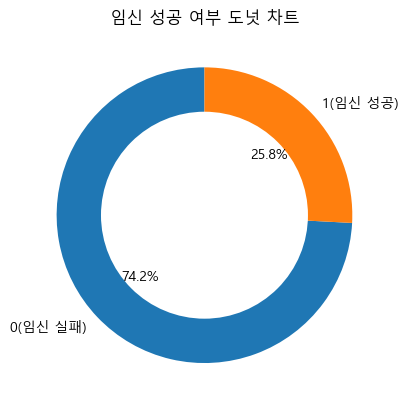

In [200]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

## EDA

In [201]:
# '시술_유형' 변수의 값이 'IVF'에 해당 안하는 데이터 추출
IVF_train = train[train['시술_유형'] == 'IVF'] # 
IVF_test = test[test['시술_유형'] == 'IVF']

# 새로운 데이터셋 생성
print("시술유형 IVF 데이터셋:")
print(IVF_train)

시술유형 IVF 데이터셋:
                  ID 시술_시기_코드 시술_당시_나이  임신_시도_또는_마지막_임신_경과_연수 시술_유형 특정_시술_유형  \
0       TRAIN_000000   TRZKPL  만18-34세                    NaN   IVF     ICSI   
1       TRAIN_000001   TRYBLT  만45-50세                    NaN   IVF     ICSI   
2       TRAIN_000002   TRVNRY  만18-34세                    NaN   IVF      IVF   
3       TRAIN_000003   TRJXFG  만35-37세                    NaN   IVF     ICSI   
4       TRAIN_000004   TRVNRY  만18-34세                    NaN   IVF     ICSI   
...              ...      ...      ...                    ...   ...      ...   
256346  TRAIN_256346   TRYBLT  만18-34세                    NaN   IVF     ICSI   
256347  TRAIN_256347   TRYBLT  만38-39세                    NaN   IVF     ICSI   
256348  TRAIN_256348   TRVNRY  만35-37세                    NaN   IVF     ICSI   
256349  TRAIN_256349   TRZKPL  만38-39세                    NaN   IVF     ICSI   
256350  TRAIN_256350   TRXQMD  만35-37세                    NaN   IVF      IVF   

        배란_자극_여부    배란_유

In [202]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 256351 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     256351 non-null  object 
 1   시술_시기_코드               256351 non-null  object 
 2   시술_당시_나이               256351 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9370 non-null    float64
 4   시술_유형                  256351 non-null  object 
 5   특정_시술_유형               256349 non-null  object 
 6   배란_자극_여부               256351 non-null  int64  
 7   배란_유도_유형               256351 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             256351 non-null  int64  
 12  남성_부_불임_원인             256351 non-null  int64  
 13  여성_주_불임_원인             256351 non-null  int64  
 14  여성_부_불임_원인             256351 non-nu

In [203]:
IVF_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250060 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     250060 non-null  object 
 1   시술_시기_코드               250060 non-null  object 
 2   시술_당시_나이               250060 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9067 non-null    float64
 4   시술_유형                  250060 non-null  object 
 5   특정_시술_유형               250058 non-null  object 
 6   배란_자극_여부               250060 non-null  int64  
 7   배란_유도_유형               250060 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             250060 non-null  int64  
 12  남성_부_불임_원인             250060 non-null  int64  
 13  여성_주_불임_원인             250060 non-null  int64  
 14  여성_부_불임_원인             250060 non-nu

In [204]:
IVF_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87891 entries, 0 to 90066
Data columns (total 68 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     87891 non-null  object 
 1   시술_시기_코드               87891 non-null  object 
 2   시술_당시_나이               87891 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  3209 non-null   float64
 4   시술_유형                  87891 non-null  object 
 5   특정_시술_유형               87891 non-null  object 
 6   배란_자극_여부               87891 non-null  int64  
 7   배란_유도_유형               87891 non-null  object 
 8   단일_배아_이식_여부            87891 non-null  float64
 9   착상_전_유전_검사_사용_여부       933 non-null    float64
 10  착상_전_유전_진단_사용_여부       87891 non-null  float64
 11  남성_주_불임_원인             87891 non-null  int64  
 12  남성_부_불임_원인             87891 non-null  int64  
 13  여성_주_불임_원인             87891 non-null  int64  
 14  여성_부_불임_원인             87891 non-null  int64  
 15  부부

In [205]:
# 모든 값이 결측값인 변수를 제거
IVF_train = IVF_train.dropna(axis=1, how='all')
IVF_test = IVF_test.dropna(axis=1, how='all')

In [206]:
train = IVF_train
test = IVF_test

In [207]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250060 entries, 0 to 256350
Data columns (total 69 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     250060 non-null  object 
 1   시술_시기_코드               250060 non-null  object 
 2   시술_당시_나이               250060 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  9067 non-null    float64
 4   시술_유형                  250060 non-null  object 
 5   특정_시술_유형               250058 non-null  object 
 6   배란_자극_여부               250060 non-null  int64  
 7   배란_유도_유형               250060 non-null  object 
 8   단일_배아_이식_여부            250060 non-null  float64
 9   착상_전_유전_검사_사용_여부       2718 non-null    float64
 10  착상_전_유전_진단_사용_여부       250060 non-null  float64
 11  남성_주_불임_원인             250060 non-null  int64  
 12  남성_부_불임_원인             250060 non-null  int64  
 13  여성_주_불임_원인             250060 non-null  int64  
 14  여성_부_불임_원인             250060 non-nu

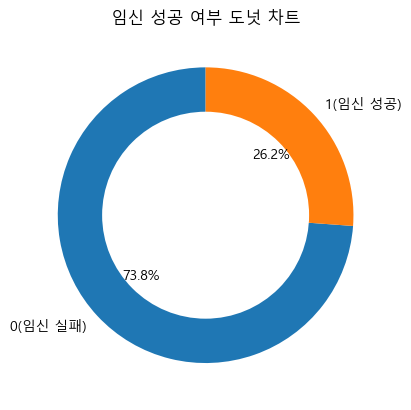

In [208]:
import matplotlib.pyplot as plt
import pandas as pd

# '임신_성공_여부' 변수의 값 개수 계산
value_counts = train['임신_성공_여부'].value_counts()

# 라벨 변경
labels = {1: '1(임신 성공)', 0: '0(임신 실패)'}
value_counts.index = value_counts.index.map(labels)

# 도넛 차트 그리기
fig, ax = plt.subplots()

# 파이 차트 그리기
wedges, texts, autotexts = ax.pie(value_counts, labels=value_counts.index, autopct='%1.1f%%', startangle=90, wedgeprops=dict(width=0.5))

# 도넛 차트 가운데에 원 그리기
centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig.gca().add_artist(centre_circle)

# 차트 제목 설정
ax.set_title('임신 성공 여부 도넛 차트')

# 차트 표시
plt.show()

### 1. 시술_시기_코드

난임 시술을 받은 시기를 기준으로 코드 부여

In [209]:
value_counts_ratio(train, '시술_시기_코드')


시술_시기_코드별 임신_성공_여부 비율 및 갯수

                 0         1      0     1  Total
variable                                        
TRCMWS    0.739895  0.260105  27567  9691  37258
TRDQAZ    0.751191  0.248809  28549  9456  38005
TRJXFG    0.730081  0.269919  25693  9499  35192
TRVNRY    0.736404  0.263596  25917  9277  35194
TRXQMD    0.741403  0.258597  25161  8776  33937
TRYBLT    0.727689  0.272311  26092  9764  35856
TRZKPL    0.741348  0.258652  25664  8954  34618


## 2. 시술 당시 나이

환자의 시술 당시 나이(연령대)

In [210]:
value_counts_ratio(train, '시술_당시_나이')


시술_당시_나이별 임신_성공_여부 비율 및 갯수

                 0         1        0        1   Total
variable                                              
만18-34세   0.674737  0.325263  67747.0  32658.0  100405
만35-37세   0.718321  0.281679  40463.0  15867.0   56330
만38-39세   0.779704  0.220296  29780.0   8414.0   38194
만40-42세   0.838043  0.161957  30431.0   5881.0   36312
만43-44세   0.878486  0.121514  10396.0   1438.0   11834
만45-50세   0.825871  0.174129   5497.0   1159.0    6656
알 수 없음    1.000000  0.000000    329.0      0.0     329


In [211]:
test['시술_당시_나이'].value_counts()

만18-34세    35498
만35-37세    19687
만38-39세    13228
만40-42세    12911
만43-44세     4123
만45-50세     2328
알 수 없음       116
Name: 시술_당시_나이, dtype: int64

## 3. 임신 시도 또는 마지막 임신 경과 일수

환자가 처음 임신을 시도한 시점 또는 마지막 임신 이후 현재까지의 경과 연수 (년 단위)

In [212]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1    0    1  Total
variable                                     
0.0       0.666667  0.333333    8    4     12
1.0       0.500000  0.500000    2    2      4
2.0       0.809524  0.190476   17    4     21
3.0       0.762500  0.237500   61   19     80
4.0       0.759322  0.240678  224   71    295
5.0       0.753687  0.246313  511  167    678
6.0       0.747126  0.252874  715  242    957
7.0       0.765453  0.234547  904  277   1181
8.0       0.782379  0.217621  888  247   1135
9.0       0.790744  0.209256  786  208    994
10.0      0.778384  0.221616  713  203    916
11.0      0.808036  0.191964  543  129    672
12.0      0.776639  0.223361  379  109    488
13.0      0.835853  0.164147  387   76    463
14.0      0.775701  0.224299  249   72    321
15.0      0.791165  0.208835  197   52    249
16.0      0.845771  0.154229  170   31    201
17.0      0.820896  0.179104  110   24    134
18.0      0.836538  0.163462   87   17

In [213]:
# 결측값 개수 확인
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

# 결측값을 known으로 채우기
train['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)
test['임신_시도_또는_마지막_임신_경과_연수'].fillna('unknown', inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum())

결측값 개수: 240993
결측값 개수: 0


In [214]:
test['임신_시도_또는_마지막_임신_경과_연수'].isnull().sum()

0

In [215]:
value_counts_ratio(train, '임신_시도_또는_마지막_임신_경과_연수')


임신_시도_또는_마지막_임신_경과_연수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.666667  0.333333       8      4      12
1.0       0.500000  0.500000       2      2       4
2.0       0.809524  0.190476      17      4      21
3.0       0.762500  0.237500      61     19      80
4.0       0.759322  0.240678     224     71     295
5.0       0.753687  0.246313     511    167     678
6.0       0.747126  0.252874     715    242     957
7.0       0.765453  0.234547     904    277    1181
8.0       0.782379  0.217621     888    247    1135
9.0       0.790744  0.209256     786    208     994
10.0      0.778384  0.221616     713    203     916
11.0      0.808036  0.191964     543    129     672
12.0      0.776639  0.223361     379    109     488
13.0      0.835853  0.164147     387     76     463
14.0      0.775701  0.224299     249     72     321
15.0      0.791165  0.208835     197     52     249
16.0      0.845771  0.

## 4. 시술_유형

IVF 또는 DI 시술 여부

In [216]:
value_counts_ratio(train, '시술_유형')


시술_유형별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
IVF       0.738395  0.261605  184643  65417  250060


In [217]:
test['시술_유형'].value_counts()

IVF    87891
Name: 시술_유형, dtype: int64

IVF 와 DI 시술중 IVF 시술 데이터만 제공됨

In [218]:
# '시술_유형' 변수 제거
train = train.drop(columns=['시술_유형'])
test = test.drop(columns=['시술_유형'])

In [219]:
len(train['임신_성공_여부'])

250060

## 5. 특정_시술_유형

IVF – 체외 수정 (시험관 아기 시술)  
ICSI – 세포질 내 정자 주입  
IUI – 인공 수정 (자궁 내 주입)  
ICI – 자궁경부 인공 수정  
GIFT – 생식세포 나팔관 이식  
FER – 냉동 배아 이식  
Generic DI – 기증 정자 주입  
IVI – 질 내 인공 수정   
BLASTOCYST – 배반포 단계에 이식  
AH – 배아를 hatching 시켜주는 과정  
Unknown – 시술 유형 정보가 제공되지 않았거나 알 수 없음  

(*) 특수 기호의 의미  
"/" – 복합적인 시술 방법을 의미 (예: ICSI / BLASTOCYST)  
":" – 동일 시술 내 세부 조합을 의미 (예: ICSI:IVF)  

In [220]:
len(train['특정_시술_유형'])

250060

시술유형에 대해서 특정 시술 유형값이 존재하는거!

In [221]:
summarize_group(train, ['특정_시술_유형'])

Grouped by: 특정_시술_유형

                                  group  '임신_성공_여부' count     ratio   Total
0                                   FER                 1  0.333333       3
1                                  GIFT                 0  0.000000       1
2                                  ICSI             33385  0.272825  122368
3                             ICSI / AH               167  0.217165     769
4                     ICSI / AH:Unknown                 1  0.500000       2
5                    ICSI / BLASTOCYST                574  0.356743    1609
6               ICSI / BLASTOCYST :ICSI                 1  1.000000       1
7   ICSI / BLASTOCYST :IVF / BLASTOCYST                 1  0.250000       4
8    ICSI / BLASTOCYST:IVF / BLASTOCYST                 2  0.333333       6
9                             ICSI:ICSI                23  0.009939    2314
10                             ICSI:IVF               205  0.234822     873
11                         ICSI:Unknown                21  0.10144

In [222]:
# '특정_시술_유형' 변수의 값이 'FER' 또는 'GIFT'인 행 제거
train = train.loc[~train['특정_시술_유형'].isin(['FER', 'GIFT'])]
test = test.loc[~test['특정_시술_유형'].isin(['FER', 'GIFT'])]

In [223]:
# 시술 유형 변환 함수
def transform_treatment(treatment):
    if isinstance(treatment, str):  # treatment가 문자열인지 확인
        if treatment.startswith("ICSI"):
            if "AH" in treatment:
                return "ICSI / AH"
            elif "BLASTOCYST" in treatment:
                return "ICSI / BLASTOCYST"
            return "ICSI"
        elif treatment.startswith("IVF"):
            if "AH" in treatment:
                return "IVF / AH"
            elif "BLASTOCYST" in treatment:
                return "IVF / BLASTOCYST"
            return "IVF"
    return treatment  # 기타 시술은 그대로 반환

# 변환된 열 추가
train['변환된_특정_시술_유형'] = train['특정_시술_유형'].apply(transform_treatment)
test['변환된_특정_시술_유형'] = test['특정_시술_유형'].apply(transform_treatment)

In [224]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1      0      1   Total
variable                                                   
ICSI               0.732558  0.267442  92128  33634  125762
ICSI / AH          0.782101  0.217899    603    168     771
ICSI / BLASTOCYST  0.643210  0.356790   1042    578    1620
IVF                0.741629  0.258371  69263  24130   93393
IVF / AH           0.816199  0.183801    262     59     321
IVF / BLASTOCYST   0.633814  0.366186    791    457    1248
Unknown            0.762797  0.237203  20549   6390   26939


In [225]:
value_counts_ratio(train, '변환된_특정_시술_유형')


변환된_특정_시술_유형별 임신_성공_여부 비율 및 갯수

                          0         1      0      1   Total
variable                                                   
ICSI               0.732558  0.267442  92128  33634  125762
ICSI / AH          0.782101  0.217899    603    168     771
ICSI / BLASTOCYST  0.643210  0.356790   1042    578    1620
IVF                0.741629  0.258371  69263  24130   93393
IVF / AH           0.816199  0.183801    262     59     321
IVF / BLASTOCYST   0.633814  0.366186    791    457    1248
Unknown            0.762797  0.237203  20549   6390   26939


In [226]:
test['변환된_특정_시술_유형'].value_counts()

ICSI                 44400
IVF                  32931
Unknown               9216
ICSI / BLASTOCYST      586
IVF / BLASTOCYST       389
ICSI / AH              264
IVF / AH               105
Name: 변환된_특정_시술_유형, dtype: int64

In [227]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['특정_시술_유형'])
test = test.drop(columns=['특정_시술_유형'])

## 착상_전_유전_검사_사용_여부

In [228]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.851729  0.148271  2315  403   2718


In [229]:
# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['착상_전_유전_검사_사용_여부'].fillna('0', inplace=True)
test['착상_전_유전_검사_사용_여부'].fillna('0', inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['착상_전_유전_검사_사용_여부'].isnull().sum())

결측값 개수: 247338
결측값 개수: 0


In [230]:
value_counts_ratio(train, '착상_전_유전_검사_사용_여부')


착상_전_유전_검사_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
1.0       0.851729  0.148271    2315    403    2718
0         0.737149  0.262851  182325  65013  247338


## 10. 남성_주_불임_원인

남성의 주요 불임 원인 여부

In [231]:
value_counts_ratio(train, '남성_주_불임_원인')


남성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737220  0.262780  179168  63864  243032
1         0.779043  0.220957    5472   1552    7024


## 11. 남성_부_불임_원인

남성의 부차적 불임 원인 여부

In [232]:
value_counts_ratio(train, '남성_부_불임_원인')


남성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737588  0.262412  182050  64768  246818
1         0.799876  0.200124    2590    648    3238


## 12. 여성_주_불임_원인

여성의 주요 불임 원인 여부

In [233]:
value_counts_ratio(train, '여성_주_불임_원인')


여성_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737169  0.262831  178827  63759  242586
1         0.778179  0.221821    5813   1657    7470


## 13. 여성_부_불임_원인

여성의 부차적 불임 원인 여부

In [234]:
value_counts_ratio(train, '여성_부_불임_원인')


여성_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737606  0.262394  182188  64811  246999
1         0.802094  0.197906    2452    605    3057


## 14. 부부_주_불임_원인

부부의 주요 불임 원인 여부

In [235]:
value_counts_ratio(train, '부부_주_불임_원인')


부부_주_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737053  0.262947  178327  63619  241946
1         0.778422  0.221578    6313   1797    8110


## 15. 부부_부_불임_원인

부부의 부차적 불임 원인 여부

In [236]:
value_counts_ratio(train, '부부_부_불임_원인')


부부_부_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737751  0.262249  182870  65005  247875
1         0.811554  0.188446    1770    411    2181


## 16. 불명확_불임_원인

불명의 원인으로 인한 불임 여부

In [237]:
value_counts_ratio(train, '불명확_불임_원인')


불명확_불임_원인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.738087  0.261913  137476  48784  186260
1         0.739294  0.260706   47164  16632   63796


## 17. 불임_원인_-_난관_질환

난관 이상으로 인한 불임 여부

In [238]:
value_counts_ratio(train, '불임_원인_-_난관_질환')


불임_원인_-_난관_질환별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737822  0.262178  158319  56257  214576
1         0.741855  0.258145   26321   9159   35480


## 18. 불임_원인_-_남성_요인

남성 요인으로 인한 불임 여부

In [239]:
value_counts_ratio(train, '불임_원인_-_남성_요인')


불임_원인_-_남성_요인별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.751365  0.248635  118319  39153  157472
1         0.716333  0.283667   66321  26263   92584


## 19. 불임_원인_-_배란_장애

배란 장애로 인한 불임 여부

In [240]:
value_counts_ratio(train, '불임_원인_-_배란_장애')


불임_원인_-_배란_장애별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.742480  0.257520  161127  55885  217012
1         0.711566  0.288434   23513   9531   33044


## 22. 불임_원인_-_자궁내막증

자궁내막증으로 인한 불임 여부

In [241]:
value_counts_ratio(train, '불임_원인_-_자궁내막증')


불임_원인_-_자궁내막증별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.737988  0.262012  171152  60765  231917
1         0.743591  0.256409   13488   4651   18139


## 23. 불임_원인_-_정자_농도

파트너의 정자 농도 문제 여부

In [242]:
value_counts_ratio(train, '불임_원인_-_정자_농도')


불임_원인_-_정자_농도별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.738391  0.261609  184464  65355  249819
1         0.742616  0.257384     176     61     237


## 26. 불임_원인_-_정자_형태

파트너의 정자 형태 문제 여부

In [243]:
value_counts_ratio(train, '불임_원인_-_정자_형태')


불임_원인_-_정자_형태별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0         0.738375  0.261625  184531  65384  249915
1         0.773050  0.226950     109     32     141


## 28. 총_시술_횟수

IVF 및 DI 포함한 전체 시술 횟수

In [244]:
value_counts_ratio(train, '총_시술_횟수')


총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0회        0.708123  0.291877  68831  28371  97202
1회        0.748185  0.251815  41837  14081  55918
2회        0.752661  0.247339  28775   9456  38231
3회        0.758631  0.241369  17821   5670  23491
4회        0.767004  0.232996  10916   3316  14232
5회        0.776622  0.223378   6498   1869   8367
6회 이상     0.789695  0.210305   9962   2653  12615


In [245]:
test['총_시술_횟수'].value_counts()

0회       34249
1회       19667
2회       13346
3회        8257
4회        4977
6회 이상     4372
5회        3023
Name: 총_시술_횟수, dtype: int64

## 29. 클리닉_내_총_시술_횟수

특정 클리닉에서 받은 IVF 및 DI 시술 횟수

In [246]:
value_counts_ratio(train, '클리닉_내_총_시술_횟수')


클리닉_내_총_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0회        0.715733  0.284267  86429  34327  120756
1회        0.752288  0.247712  44063  14509   58572
2회        0.758241  0.241759  25326   8075   33401
3회        0.761820  0.238180  13277   4151   17428
4회        0.770382  0.229618   7106   2118    9224
5회        0.782837  0.217163   3731   1035    4766
6회 이상     0.796751  0.203249   4708   1201    5909


## 30. IVF_시술_횟수

이전에 수행된 IVF 시술 횟수

In [247]:
value_counts_ratio(train, 'IVF_시술_횟수')


IVF_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1      0      1   Total
variable                                          
0회        0.708231  0.291769  70957  29232  100189
1회        0.747426  0.252574  42903  14498   57401
2회        0.752339  0.247661  29026   9555   38581
3회        0.762390  0.237610  17429   5432   22861
4회        0.770207  0.229793  10320   3079   13399
5회        0.784339  0.215661   5990   1647    7637
6회 이상     0.802463  0.197537   8015   1973    9988


## 31. DI_시술_횟수

이전에 수행된 DI 시술 횟수

In [248]:
value_counts_ratio(train, 'DI_시술_횟수')


DI_시술_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0회        0.738589  0.261411  178243  63086  241329
1회        0.760754  0.239246    1291    406    1697
2회        0.735436  0.264564    1376    495    1871
3회        0.711382  0.288618    1575    639    2214
4회        0.724036  0.275964     732    279    1011
5회        0.739617  0.260383     463    163     626
6회 이상     0.733945  0.266055     960    348    1308


## 32. 총_임신_횟수

IVF 및 DI 포함한 총 임신 횟수

In [249]:
value_counts_ratio(train, '총_임신_횟수')


총_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0회        0.739574  0.260426  149155  52522  201677
1회        0.732256  0.267744   30508  11155   41663
2회        0.739652  0.260348    4378   1541    5919
3회        0.748571  0.251429     524    176     700
4회        0.770115  0.229885      67     20      87
5회        0.857143  0.142857       6      1       7
6회 이상     0.666667  0.333333       2      1       3


## 33. IVF_임신_횟수

IVF 시술로 인한 임신 횟수

In [250]:
value_counts_ratio(train, 'IVF_임신_횟수')


IVF_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.739486  0.260514  149689.0  52734.0  202423
1회        0.732116  0.267884   30109.0  11017.0   41126
2회        0.742922  0.257078    4277.0   1480.0    5757
3회        0.751891  0.248109     497.0    164.0     661
4회        0.765432  0.234568      62.0     19.0      81
5회        0.857143  0.142857       6.0      1.0       7
6회 이상     0.000000  1.000000       0.0      1.0       1


## 34. DI_임신_횟수

DI 시술로 인한 임신 횟수

In [251]:
value_counts_ratio(train, 'DI_임신_횟수')


DI_임신_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.738510  0.261490  184019.0  65157.0  249176
1회        0.711111  0.288889     544.0    221.0     765
2회        0.653465  0.346535      66.0     35.0     101
3회        0.727273  0.272727       8.0      3.0      11
4회        1.000000  0.000000       1.0      0.0       1
5회        1.000000  0.000000       2.0      0.0       2


## 35. 총_출산_횟수

IVF 및 DI 시술로 출산한 횟수

In [252]:
value_counts_ratio(train, '총_출산_횟수')


총_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.739998  0.260002  158526.0  55699.0  214225
1회        0.728675  0.271325   24466.0   9110.0   33576
2회        0.732186  0.267814    1531.0    560.0    2091
3회        0.702703  0.297297     104.0     44.0     148
4회        0.769231  0.230769      10.0      3.0      13
5회        1.000000  0.000000       1.0      0.0       1
6회 이상     1.000000  0.000000       2.0      0.0       2


## 36. IVF_출산_횟수

IVF 시술로 출산한 횟수

In [253]:
value_counts_ratio(train, 'IVF_출산_횟수')


IVF_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.739899  0.260101  158937.0  55872.0  214809
1회        0.728834  0.271166   24112.0   8971.0   33083
2회        0.737208  0.262792    1484.0    529.0    2013
3회        0.700730  0.299270      96.0     41.0     137
4회        0.769231  0.230769      10.0      3.0      13
5회        1.000000  0.000000       1.0      0.0       1


## 37. DI_출산_횟수

DI 시술로 출산한 횟수

In [254]:
value_counts_ratio(train, 'DI_출산_횟수')


DI_출산_횟수별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0회        0.738499  0.261501  184198.0  65224.0  249422
1회        0.699313  0.300687     407.0    175.0     582
2회        0.666667  0.333333      32.0     16.0      48
3회        0.500000  0.500000       1.0      1.0       2
5회        1.000000  0.000000       2.0      0.0       2


## 55. 정자_기증자_나이

정자 기증자의 등록 당시 나이

In [255]:
value_counts_ratio(train, '정자_기증자_나이')


정자_기증자_나이별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
만20세 이하   0.761842  0.238158     579    181     760
만21-25세   0.727231  0.272769    3202   1201    4403
만26-30세   0.715022  0.284978    2775   1106    3881
만31-35세   0.717001  0.282999    2716   1072    3788
만36-40세   0.717344  0.282656    2949   1162    4111
만41-45세   0.723903  0.276097    2129    812    2941
알 수 없음    0.739838  0.260162  170290  59882  230172


## 56. 동결_배아_사용_여부

동결 배아가 사용되었는지 여부

In [256]:
value_counts_ratio(train, '동결_배아_사용_여부')


동결_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.732236  0.267764  153719  56212  209931
1.0       0.770617  0.229383   30921   9204   40125


## 57. 신선_배아_사용_여부

신선 배아가 사용되었는지 여부

In [257]:
value_counts_ratio(train, '신선_배아_사용_여부')


신선_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.770433  0.229567   30758   9165   39923
1.0       0.732308  0.267692  153882  56251  210133


## 58. 기증_배아_사용_여부

기증 배아가 사용되었는지 여부

In [258]:
value_counts_ratio(train, '기증_배아_사용_여부')


기증_배아_사용_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.739049  0.260951  182987  64611  247598
1.0       0.672498  0.327502    1653    805    2458


## 59. 대리모_여부

환자가 대리모로 활동했는지 여부

In [259]:
value_counts_ratio(train, '대리모_여부')


대리모_여부별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.738509  0.261491  183894  65113  249007
1.0       0.711153  0.288847     746    303    1049


## 60. PGD_시술_여부

해당 주기가 PGD 치료로 분류되는지 여부

In [260]:
value_counts_ratio(train, 'PGD_시술_여부')


PGD_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.720514  0.279486  1570  609   2179


In [261]:
train['PGD_시술_여부'].isnull().sum()

247877

In [262]:
# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGD_시술_여부'].fillna('0', inplace=True)
test['PGD_시술_여부'].fillna('0', inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGD_시술_여부'].isnull().sum())

결측값 개수: 247877
결측값 개수: 0


## 61. PGS_시술_여부

해당 주기가 PGS 치료로 분류되는지 여부

In [263]:
value_counts_ratio(train, 'PGS_시술_여부')


PGS_시술_여부별 임신_성공_여부 비율 및 갯수

                 0         1     0    1  Total
variable                                      
1.0       0.793675  0.206325  1531  398   1929


In [264]:
# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

# 결측값을 0으로 채우기
train['PGS_시술_여부'].fillna('0', inplace=True)
test['PGS_시술_여부'].fillna('0', inplace=True)

# 결측값 개수 확인
print("결측값 개수:", train['PGS_시술_여부'].isnull().sum())

결측값 개수: 248127
결측값 개수: 0


## 62. 난자_채취_경과일

첫 시점으로부터 난자 채취까지 경과한 일수

In [265]:
value_counts_ratio(train, '난자_채취_경과일')


난자_채취_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0      1   Total
variable                                           
0.0       0.736181  0.263819  146397  52463  198860


In [266]:
# '특정_시술_유형' 변수 제거
train = train.drop(columns=['난자_채취_경과일'])
test = test.drop(columns=['난자_채취_경과일'])

## 63. 난자_해동_경과일

첫 시점으로부터 난자 해동까지 경과한 일수

In [267]:
value_counts_ratio(train, '난자_해동_경과일')


난자_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1       0      1  Total
variable                                          
0.0       0.777545  0.222455  1115.0  319.0   1434
1.0       1.000000  0.000000     2.0    0.0      2


In [268]:
train['난자_해동_경과일'].isnull().sum()

248620

In [269]:
print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

train['난자_해동_경과일'].fillna('unknown', inplace=True)
test['난자_해동_경과일'].fillna('unknown', inplace=True)

print("결측값 개수:", train['난자_해동_경과일'].isnull().sum())

결측값 개수: 248620
결측값 개수: 0


## 64. 난자_혼합_경과일

첫 시점으로부터 난자와 정자 혼합까지 경과한 일수

In [270]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.722921  0.277079  145970.0  55947.0  201917
1.0       0.846311  0.153689     413.0     75.0     488
2.0       0.754902  0.245098      77.0     25.0     102
3.0       0.720588  0.279412      49.0     19.0      68
4.0       0.600000  0.400000       3.0      2.0       5
5.0       0.791667  0.208333      19.0      5.0      24
6.0       1.000000  0.000000       8.0      0.0       8
7.0       1.000000  0.000000       1.0      0.0       1


In [271]:
train['난자_혼합_경과일'].isnull().sum()

47443

In [272]:
print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

train['난자_혼합_경과일'].fillna('unknown', inplace=True)
test['난자_혼합_경과일'].fillna('unknown', inplace=True)

print("결측값 개수:", train['난자_혼합_경과일'].isnull().sum())

결측값 개수: 47443
결측값 개수: 0


In [273]:
value_counts_ratio(train, '난자_혼합_경과일')


난자_혼합_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.722921  0.277079  145970.0  55947.0  201917
1.0       0.846311  0.153689     413.0     75.0     488
2.0       0.754902  0.245098      77.0     25.0     102
3.0       0.720588  0.279412      49.0     19.0      68
4.0       0.600000  0.400000       3.0      2.0       5
5.0       0.791667  0.208333      19.0      5.0      24
6.0       1.000000  0.000000       8.0      0.0       8
7.0       1.000000  0.000000       1.0      0.0       1
unknown   0.803069  0.196931   38100.0   9343.0   47443


## 65. 배아_이식_경과일

첫 시점으로부터 배아 이식까지 경과한 일수

In [274]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0.0       0.748986  0.251014  18652   6251  24903
1.0       0.812985  0.187015   4921   1132   6053
2.0       0.787531  0.212469  27625   7453  35078
3.0       0.741230  0.258770  42935  14989  57924
4.0       0.655639  0.344361   2953   1551   4504
5.0       0.595546  0.404454  48512  32946  81458
6.0       0.699964  0.300036   1941    832   2773
7.0       0.588889  0.411111     53     37     90


In [275]:
train['배아_이식_경과일'].isnull().sum()

37273

In [276]:
print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

train['배아_이식_경과일'].fillna('unknown', inplace=True)
test['배아_이식_경과일'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_이식_경과일'].isnull().sum())

결측값 개수: 37273
결측값 개수: 0


In [277]:
value_counts_ratio(train, '배아_이식_경과일')


배아_이식_경과일별 임신_성공_여부 비율 및 갯수

                 0         1      0      1  Total
variable                                         
0.0       0.748986  0.251014  18652   6251  24903
1.0       0.812985  0.187015   4921   1132   6053
2.0       0.787531  0.212469  27625   7453  35078
3.0       0.741230  0.258770  42935  14989  57924
4.0       0.655639  0.344361   2953   1551   4504
5.0       0.595546  0.404454  48512  32946  81458
6.0       0.699964  0.300036   1941    832   2773
7.0       0.588889  0.411111     53     37     90
unknown   0.993963  0.006037  37048    225  37273


## 66. 배아_해동_경과일

첫 시점으로부터 배아 해동까지 경과한 일수

In [278]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1        0       1  Total
variable                                            
0.0       0.770352  0.229648  30660.0  9140.0  39800
1.0       0.837838  0.162162     31.0     6.0     37
2.0       0.840659  0.159341    153.0    29.0    182
3.0       0.890244  0.109756    146.0    18.0    164
4.0       1.000000  0.000000     12.0     0.0     12
5.0       0.785714  0.214286    110.0    30.0    140
6.0       0.833333  0.166667     25.0     5.0     30
7.0       1.000000  0.000000      3.0     0.0      3


In [279]:
test['배아_해동_경과일'].value_counts()

0.0    13751
3.0       59
2.0       57
5.0       55
1.0       17
6.0        7
4.0        4
Name: 배아_해동_경과일, dtype: int64

In [280]:
print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

train['배아_해동_경과일'].fillna('unknown', inplace=True)
test['배아_해동_경과일'].fillna('unknown', inplace=True)

print("결측값 개수:", train['배아_해동_경과일'].isnull().sum())

결측값 개수: 209688
결측값 개수: 0


In [281]:
value_counts_ratio(train, '배아_해동_경과일')


배아_해동_경과일별 임신_성공_여부 비율 및 갯수

                 0         1         0        1   Total
variable                                               
0.0       0.770352  0.229648   30660.0   9140.0   39800
1.0       0.837838  0.162162      31.0      6.0      37
2.0       0.840659  0.159341     153.0     29.0     182
3.0       0.890244  0.109756     146.0     18.0     164
4.0       1.000000  0.000000      12.0      0.0      12
5.0       0.785714  0.214286     110.0     30.0     140
6.0       0.833333  0.166667      25.0      5.0      30
7.0       1.000000  0.000000       3.0      0.0       3
unknown   0.732040  0.267960  153500.0  56188.0  209688


## 67. 임신_성공_여부

해당 시술로부터 임신 성공 여부

In [282]:
value_counts_ratio(train, '임신_성공_여부')


임신_성공_여부별 임신_성공_여부 비율 및 갯수

            0    1         0        1   Total
variable                                     
0         1.0  0.0  184640.0      0.0  184640
1         0.0  1.0       0.0  65416.0   65416


In [283]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 250056 entries, 0 to 256350
Data columns (total 67 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   ID                     250056 non-null  object 
 1   시술_시기_코드               250056 non-null  object 
 2   시술_당시_나이               250056 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  250056 non-null  object 
 4   배란_자극_여부               250056 non-null  int64  
 5   배란_유도_유형               250056 non-null  object 
 6   단일_배아_이식_여부            250056 non-null  float64
 7   착상_전_유전_검사_사용_여부       250056 non-null  object 
 8   착상_전_유전_진단_사용_여부       250056 non-null  float64
 9   남성_주_불임_원인             250056 non-null  int64  
 10  남성_부_불임_원인             250056 non-null  int64  
 11  여성_주_불임_원인             250056 non-null  int64  
 12  여성_부_불임_원인             250056 non-null  int64  
 13  부부_주_불임_원인             250056 non-null  int64  
 14  부부_부_불임_원인             250056 non-nu

In [284]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 87891 entries, 0 to 90066
Data columns (total 66 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   ID                     87891 non-null  object 
 1   시술_시기_코드               87891 non-null  object 
 2   시술_당시_나이               87891 non-null  object 
 3   임신_시도_또는_마지막_임신_경과_연수  87891 non-null  object 
 4   배란_자극_여부               87891 non-null  int64  
 5   배란_유도_유형               87891 non-null  object 
 6   단일_배아_이식_여부            87891 non-null  float64
 7   착상_전_유전_검사_사용_여부       87891 non-null  object 
 8   착상_전_유전_진단_사용_여부       87891 non-null  float64
 9   남성_주_불임_원인             87891 non-null  int64  
 10  남성_부_불임_원인             87891 non-null  int64  
 11  여성_주_불임_원인             87891 non-null  int64  
 12  여성_부_불임_원인             87891 non-null  int64  
 13  부부_주_불임_원인             87891 non-null  int64  
 14  부부_부_불임_원인             87891 non-null  int64  
 15  불명

## 데이터 저장

In [285]:
# test 데이터셋을 CSV 파일로 저장 (UTF-8 인코딩)
train.to_csv('IVF_train_dataset.csv', index=False, encoding='utf-8')
test.to_csv('IVF_test_dataset.csv', index=False, encoding='utf-8')

.